# Evolution of citation frequencies for scientific concepts

## Setup

In [ ]:
import numpy as np
import pandas as pd
import plotnine as pn

from collections import Counter

from sciterra.librarians import SemanticScholarLibrarian
from sciterra.mapping.cartography import Cartographer
from sciterra.mapping.atlas import Atlas

In [ ]:
atlas_dir = "outputs/atlas_s2-7-20-23_uncentered_imeletal/"

In [ ]:
atl = Atlas.load(atlas_dir)

In [25]:
len(atl)

16354

## Search for concept-mentioning papers

In [ ]:
words = [
    "probability",
    "language",
    "communication",
    "vision",
    "learning",
    "network",
    "symbolic",
]

In [ ]:
# identify publications that we need to call S2 for
# note that we won't be able to get all of them,
# there might be a better solution long term 
# but this is just exploratory for now
to_retrieve = list(set([
    citation 
    for pub in atl.publications.values() 
    for word in words if word in pub.abstract.split() 
    for citation in pub.citations if citation not in atl.publications
]))

In [ ]:
len(to_retrieve)

In [ ]:
# welp, that is a ridiculous number of publications, and I can't possible retrieve all of those.

In [ ]:
to_not_retrieve = list(set([
    citation 
    for pub in atl.publications.values() 
    for word in words if word in pub.abstract.split() 
    for citation in pub.citations if citation in atl.publications
]))

In [ ]:
len(to_not_retrieve)

In [ ]:
# that is just an unusably small number.

New idea: don't use citations as a fitness signal. Use density.
Fitness is defined to be the total density scores for all papers mentioning the concept, divided by the sum of all papers densities for that year. Density already adjusts for priority.


In [ ]:
crt = Cartographer()

In [23]:
# to store the densities
word_densities_per_year = {w: {y: 0 for y in range(1900, 2024)} for w in words}

indices_to_measure = []
# to store the indices to measure
word_densities_per_year_indices = {w: {y: [] for y in range(1900, 2024)} for w in words}

for id, pub in atl.publications.items():
    for word in words:
        if word in pub.abstract.split():
            idx = atl.projection.identifier_to_index[id]
            year = pub.publication_date.year            
            indices_to_measure.append(idx)
            word_densities_per_year_indices[word][year].append(idx)

indices_to_measure = np.array(indices_to_measure)

In [24]:
measurements = crt.measure_topography(atl, publication_indices=indices_to_measure)

Computing ['density'] for 4924 publications.












100%|██████████| 4924/4924 [00:00<00:00, 5037.58it/s]


In [28]:
indices_to_densities = dict(zip(indices_to_measure, measurements))

In [72]:
for id, pub in atl.publications.items():
    for word in words:
        if word in pub.abstract.split():
            idx = atl.projection.identifier_to_index[id]
            year = pub.publication_date.year      
            word_densities_per_year[word][year] += indices_to_densities[idx]

In [ ]:
# how do I get the total number of densities per year?
# probably best to convert to 2D array.

In [31]:
# for now: just compute density of all pubs, and divide each year by this
all_densities = crt.measure_topography(atl)

Computing ['density'] for 16354 publications.
































































































 92%|█████████▏| 15080/16354 [00:09<00:00, 1371.47it/s]IOStream.flush timed out
IOStream.flush timed out


 92%|█████████▏| 15081/16354 [00:39<01:13, 17.30it/s]  IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
progress using call_size=1000:   0%|          | 0/1000 [1:43:09<?, ?it/s]


 92%|█████████▏| 15081/16354 [01:09<01:13, 17.30it/s]IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
progress using call_size=500:   0%|          | 0/500 [1:39:46<?, ?it/s]










100%|██████████| 16354/16354 [01:30<00:00, 179.96it/s]


In [73]:
# note that this isn't entirely right. 
# this calculates density for all publications that mention a particular _word_. So this will depend on the vocab size / the number of 'types' in the population
densities_per_year = dict()
for id, pub in atl.publications.items():
    year = pub.publication_date.year
    if year not in densities_per_year:
        densities_per_year[year] = 0
    idx = atl.projection.identifier_to_index[id]
    densities_per_year[year] += all_densities[idx]

In [34]:
# we should probably skip this
for id, pub in atl.publications.items():
    for word in words:
        if word in pub.abstract.split():
            idx = atl.projection.identifier_to_index[id]
            year = pub.publication_date.year
            word_densities_per_year[word][year] /= densities_per_year[year]

In [74]:
# what if we had a matrix D of shape (year, word) 
# where each entry D_{yw} represents the density of the word w at year y.

# turn a nested dict of shape (word, year) into a matrix of shape (year, word)
density_matrix = np.zeros((len(word_densities_per_year[words[0]]), len(words)))

for j, word in enumerate(words):
    for i, year in enumerate(word_densities_per_year[word]):
        density_matrix[i,j] = word_densities_per_year[word][year]
density_matrix.shape

(124, 7)

In [75]:
# now we just need \phi(x) 
# the avg word density per year -- the density for all words.
avg_word_density_per_year = np.array([np.mean(density_matrix[i]) for i in range(len(density_matrix))])
np.set_printoptions(suppress=True)
print(avg_word_density_per_year.shape)
avg_word_density_per_year

(124,)


array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,          nan,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,          nan,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,          nan,          nan,
                nan,          nan,          nan,   0.        ,
         0.        ,   0.        ,          nan,   0.  

In [83]:
density_matrix[-1,].shape
density_matrix[-1]

array([ 157.02889504,  463.00736657,  235.54982963,   56.47611392,
       1105.42426746,  412.70738367,    0.        ])

In [86]:
df = pd.DataFrame(
    density_matrix,
    columns=words,
)
df["year"] = list(word_densities_per_year[words[0]].keys())
df

,probability,language,communication,vision,learning,network,symbolic,year
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1901
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1902
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1903
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1904
...,...,...,...,...,...,...,...,...
119,316.407130,1021.405238,644.721904,292.077473,1690.714169,1011.581915,43.993699,2019
120,391.543737,1169.817461,480.877851,306.193518,2372.886005,1441.379505,44.222674,2020
121,388.818204,1131.342754,567.614477,219.799431,2104.241270,894.904330,104.834487,2021
122,342.121455,1190.737860,524.629675,192.358673,2069.952198,951.308299,29.363175,2022


In [90]:
years = list(word_densities_per_year[words[0]].keys())
data = pd.DataFrame(
    [
        (words[word_idx], years[year_idx], density_matrix[year_idx, word_idx]) for word_idx in range(len(words)) for year_idx in range(len(years))
    ],
    columns=["word", "year", "density"],
)
data

,word,year,density
0,probability,1900,0.000000
1,probability,1901,0.000000
2,probability,1902,0.000000
3,probability,1903,0.000000
4,probability,1904,0.000000
...,...,...,...
863,symbolic,2019,43.993699
864,symbolic,2020,44.222674
865,symbolic,2021,104.834487
866,symbolic,2022,29.363175


/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/U

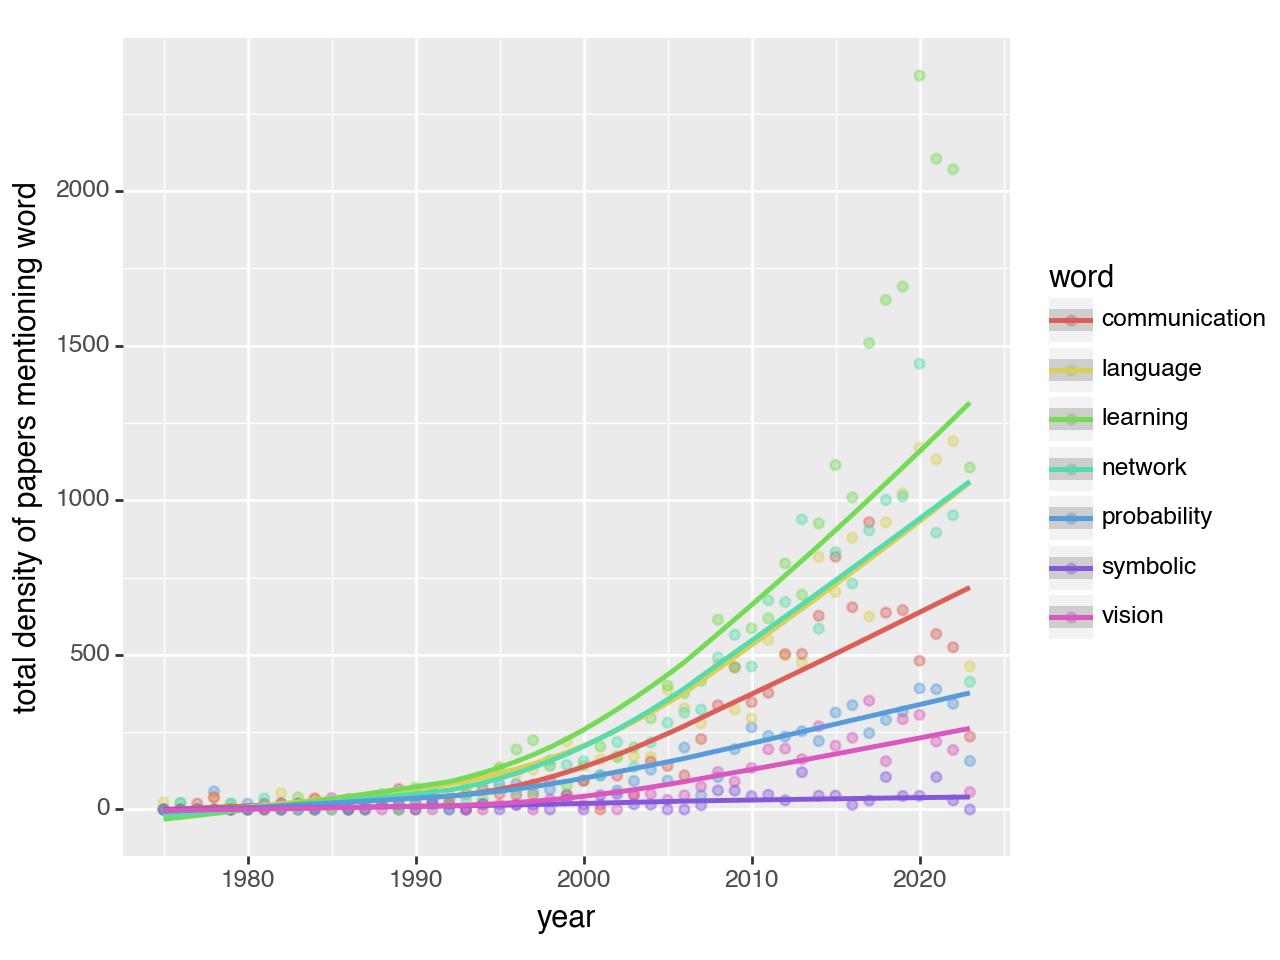

<Figure Size: (640 x 480)>

In [100]:
data["total density of papers mentioning word"] = data["density"]
(
    pn.ggplot(data, pn.aes(x="year", y="total density of papers mentioning word"))
    + pn.geom_point(
        mapping=pn.aes(
            color="word",
        ),
        alpha=0.4,
    )
    + pn.xlim(1975, 2023)    
    + pn.geom_smooth(
        mapping=pn.aes(
            color="word",
        )
    )
    + pn.xlim(1975, 2023)
)

In [102]:
# we really need the average density.
avg_density = np.mean(density_matrix, axis=1)
avg_density

array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,          nan,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,          nan,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,          nan,          nan,
                nan,          nan,          nan,   0.        ,
         0.        ,   0.        ,          nan,   0.  

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_5832/1379647697.py:3: RuntimeWarning: invalid value encountered in scalar divide
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/pytho

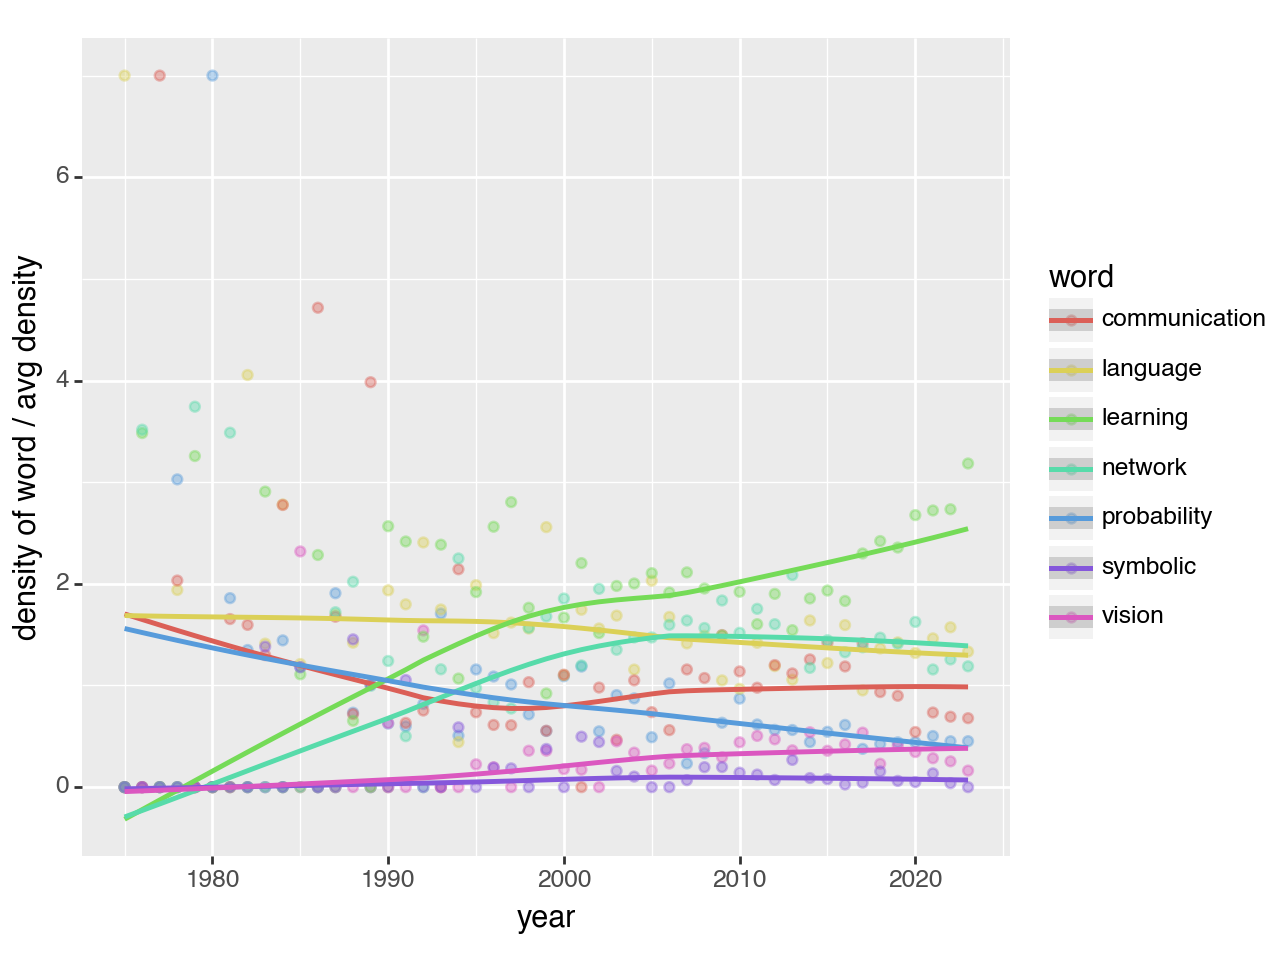

<Figure Size: (640 x 480)>

In [110]:
data = pd.DataFrame(
    [
        (words[word_idx], years[year_idx], density_matrix[year_idx, word_idx] / avg_density[year_idx]) for word_idx in range(len(words)) for year_idx in range(len(years))
    ],
    columns=["word", "year", "density"],
)
data["density of word / avg density"] = data["density"]
(
    pn.ggplot(data, pn.aes(x="year", y="density of word / avg density"))
    + pn.geom_point(
        mapping=pn.aes(
            color="word",
        ),
        alpha=0.4,
    )
    + pn.xlim(1975, 2023)    
    + pn.geom_smooth(
        mapping=pn.aes(
            color="word",
        )
    )
    + pn.xlim(1975, 2023)
)

/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/U

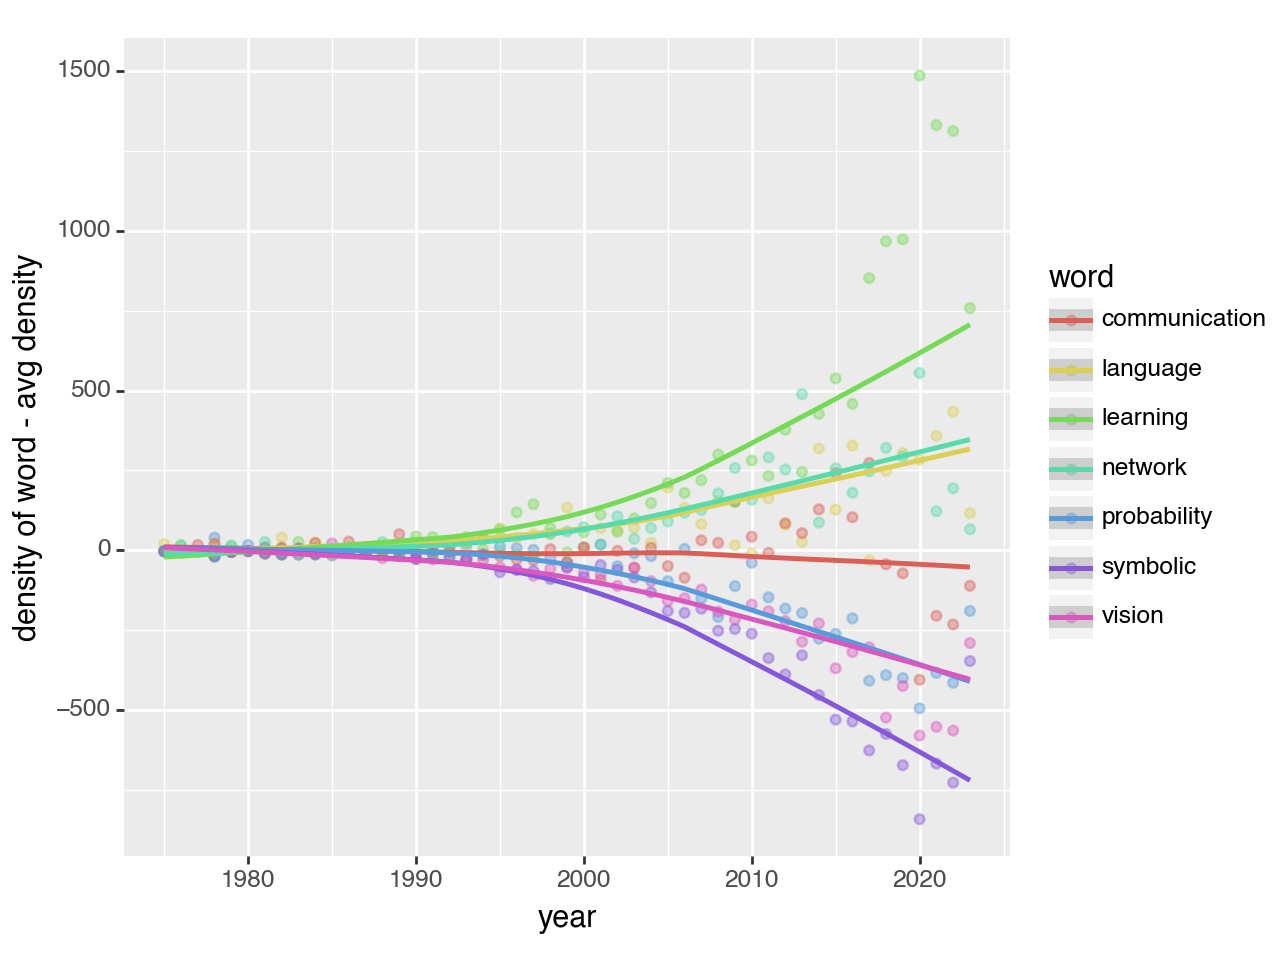

<Figure Size: (640 x 480)>

In [111]:
data = pd.DataFrame(
    [
        (words[word_idx], years[year_idx], density_matrix[year_idx, word_idx] - avg_density[year_idx]) for word_idx in range(len(words)) for year_idx in range(len(years))
    ],
    columns=["word", "year", "density"],
)
data["density of word - avg density"] = data["density"]
(
    pn.ggplot(data, pn.aes(x="year", y="density of word - avg density"))
    + pn.geom_point(
        mapping=pn.aes(
            color="word",
        ),
        alpha=0.4,
    )
    + pn.xlim(1975, 2023)    
    + pn.geom_smooth(
        mapping=pn.aes(
            color="word",
        )
    )
    + pn.xlim(1975, 2023)
)

# Citations

In [119]:
# (for each year)
# for each word, count the total citations of papers mentioning the word in the _previous_ year.

citations_word_year = {w: dict() for w in words}

# i'm not sure this gets what we want -- the total citations of papers mentioning the word in the _previous_ year.
# it probably needs like 4 more inner loops lol
# but for proof of concept lets visualize anyway
for pub in atl.publications.values():
    for word in words:
        if word in pub.abstract.split():
            for citation in pub.citations:
                if citation in atl.publications:
                    year = atl[citation].publication_date.year
                    if year > pub.publication_date.year:
                        continue
                    if year not in citations_word_year[word]:
                        citations_word_year[word][year] = 0
                    citations_word_year[word][year] += 1

citations_word_year

{'probability': {2015: 1,
  1993: 1,
  2010: 1,
  2021: 1,
  1999: 1,
  1987: 1,
  2018: 1,
  2016: 1,
  2005: 3,
  2004: 1,
  2017: 1},
 'language': {2017: 11,
  2014: 1,
  2021: 8,
  2016: 4,
  2011: 5,
  2009: 1,
  2018: 5,
  2022: 3,
  2007: 2,
  2019: 3,
  2020: 4,
  2012: 6,
  2013: 1,
  2005: 2,
  2003: 1,
  2010: 1,
  2015: 3,
  2008: 2,
  2001: 1},
 'communication': {2018: 13,
  2020: 4,
  2019: 11,
  2016: 3,
  2013: 3,
  2009: 3,
  2017: 2,
  2015: 2,
  2011: 1,
  2021: 1,
  2000: 1,
  2010: 2,
  1992: 1,
  2007: 1,
  2012: 6,
  2014: 1,
  2008: 2,
  2022: 3},
 'vision': {2020: 3,
  2019: 11,
  2018: 11,
  2016: 2,
  2013: 1,
  2009: 1,
  2010: 1,
  2007: 1,
  2004: 1},
 'learning': {2019: 7,
  2008: 3,
  2006: 2,
  2021: 9,
  2004: 1,
  2017: 10,
  1989: 1,
  1999: 1,
  2012: 3,
  2015: 1,
  2014: 3,
  2010: 2,
  2011: 3,
  1996: 1,
  2007: 1,
  2020: 3,
  2009: 1,
  2013: 1,
  2018: 3,
  2022: 2,
  2005: 1,
  2023: 1,
  2016: 2},
 'network': {2018: 4,
  2017: 2,
  2010: 2,

In [120]:
citations_matrix = np.zeros((len(years), len(words)))
for j, word in enumerate(words):
    for i, year in enumerate(years):
        count = 0
        if year in citations_word_year[word]:
            count = citations_word_year[word][year]
        citations_matrix[i,j] = count

citations_matrix[-10:, :] # last ten years

array([[ 0.,  1.,  1.,  0.,  3.,  1.,  0.],
       [ 1.,  3.,  2.,  0.,  1.,  0.,  0.],
       [ 1.,  4.,  3.,  2.,  2.,  1.,  0.],
       [ 1., 11.,  2.,  0., 10.,  2.,  0.],
       [ 1.,  5., 13., 11.,  3.,  4.,  0.],
       [ 0.,  3., 11., 11.,  7.,  2.,  0.],
       [ 0.,  4.,  4.,  3.,  3.,  5.,  0.],
       [ 1.,  8.,  1.,  0.,  9.,  2.,  1.],
       [ 0.,  3.,  3.,  0.,  2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.]])

In [121]:
data = pd.DataFrame(
    [
        (words[word_idx], years[year_idx], citations_matrix[year_idx, word_idx]) for word_idx in range(len(words)) for year_idx in range(len(years))
    ],
    columns=["word", "year", "citations that year"],
)

,word,year,citations that year
0,probability,1900,0.0
1,probability,1901,0.0
2,probability,1902,0.0
3,probability,1903,0.0
4,probability,1904,0.0
...,...,...,...
863,symbolic,2019,0.0
864,symbolic,2020,0.0
865,symbolic,2021,1.0
866,symbolic,2022,0.0


/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/scales/scales.py:50: PlotnineWarning: Scale for 'x' is already present.
Adding another scale for 'x',
which will replace the existing scale.

/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/Users/nathanielimel/miniforge3/envs/sciterra/lib/python3.11/site-packages/plotnine/stats/smoothers.py:330: PlotnineWarning: Confidence intervals are not yet implemented for lowess smoothings.
/U

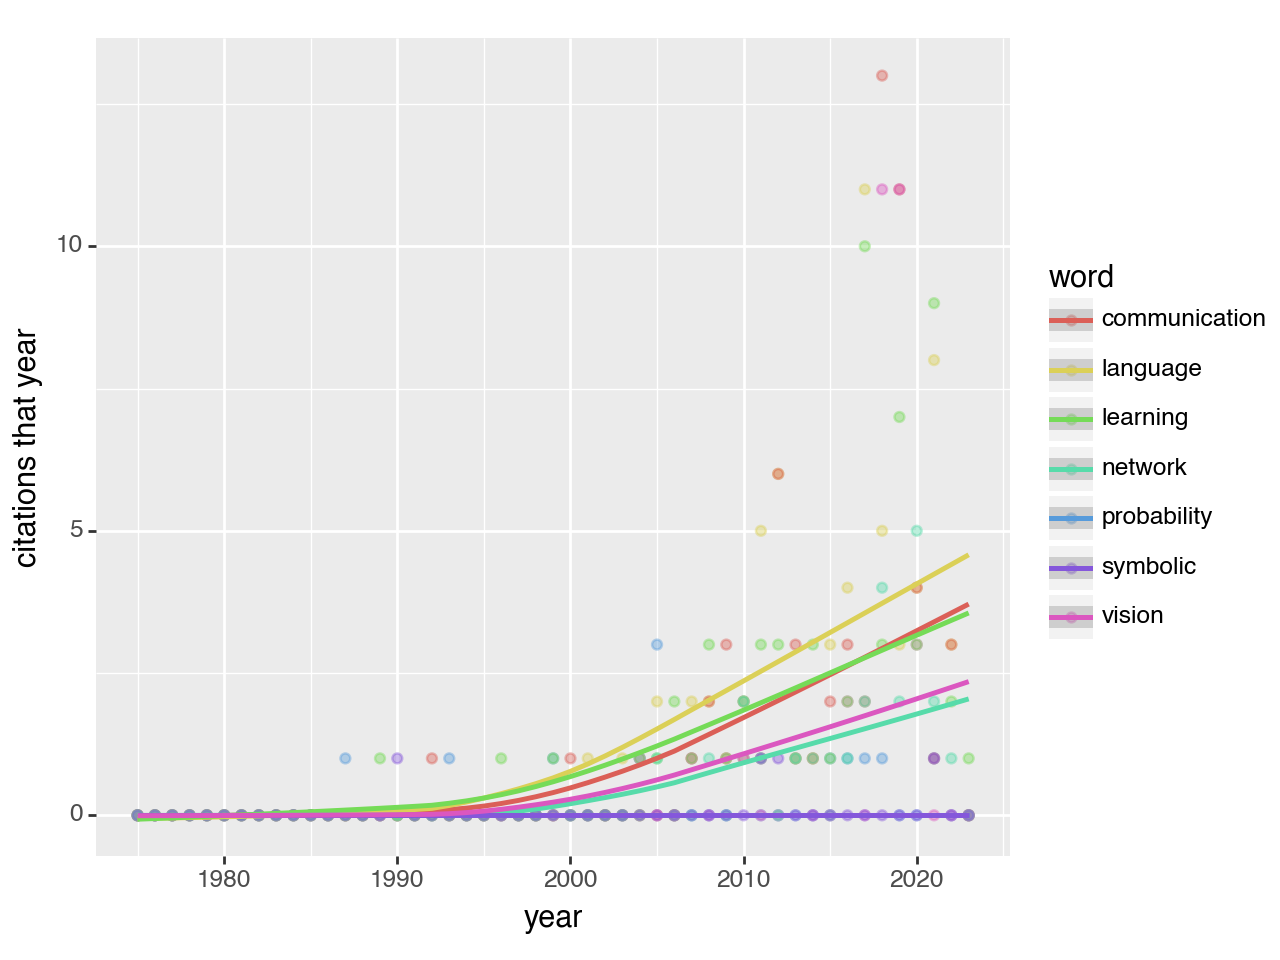

<Figure Size: (640 x 480)>

In [122]:
(
    pn.ggplot(data, pn.aes(x="year", y="citations that year"))
    + pn.geom_point(
        mapping=pn.aes(
            color="word",
        ),
        alpha=0.4,
    )
    + pn.xlim(1975, 2023)    
    + pn.geom_smooth(
        mapping=pn.aes(
            color="word",
        )
    )
    + pn.xlim(1975, 2023)
)

In [ ]:
avg_citations = np.mean(citations_matrix, axis=-1)

In [ ]:
data = pd.DataFrame(
    [
        (words[word_idx], years[year_idx], citations_matrix[year_idx, word_idx] - avg_citations[year_idx]) for word_idx in range(len(words)) for year_idx in range(len(years))
    ],
    columns=["word", "year", "citations that year - avg citations that year"],
)

# Note that these axes are sommewhat misleading -- it's not the citations per year of a concept. 
# it's the citations, THAT year, of a paper mentioning the concept that was published THAT year!
(
    pn.ggplot(data, pn.aes(x="year", y="citations that year - avg citations that year"))
    + pn.geom_point(
        mapping=pn.aes(
            color="word",
        ),
        alpha=0.4,
    )
    + pn.xlim(1975, 2023)    
    + pn.geom_smooth(
        mapping=pn.aes(
            color="word",
        )
    )
    + pn.xlim(1975, 2023)
)